# Selecting good corners in an image for tracking

In this recipe, you will learn how to detect keypoints in an image and apply simple post-processing heuristics for improving the overall quality of detected keypoints such as getting rid of keypoint clusters and removing relatively weak keypoints. This functionality is useful in such computer vision tasks as object tracking and video stabilization, since improving the quality of detected keypoints affects the final quality of the corresponding algorithms. 



In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None,
              pxstep=None,pystep=None
             ):
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pxystep; pXstep  = pxystep; pYstep  = pxystep;
    pXstep = pxstep if pxstep != None else 100
    pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img
            
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S07\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s07\env

d:\html_doc\program\opencv\packt\s07\env\lib\site-packages
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S07\env


In [2]:
image_orig = cv2.imread('../data/Lena.png', cv2.IMREAD_GRAYSCALE)



#######################################################
print_image('data/Lena.png','image_orig',image_orig,0,2,0,15)

------  data/Lena.png------------    Shape(512, 512) image_orig: uint8
[ 169 169 168 167 169 164 170 167 170 167 169 167 163 169 166 ]
[ 169 169 168 167 169 164 170 167 170 167 169 167 163 169 166 ]


------  corners------------------    Shape(100, 1, 2) corners: float32
[[180. 433.] ]
[[157. 377.] ]


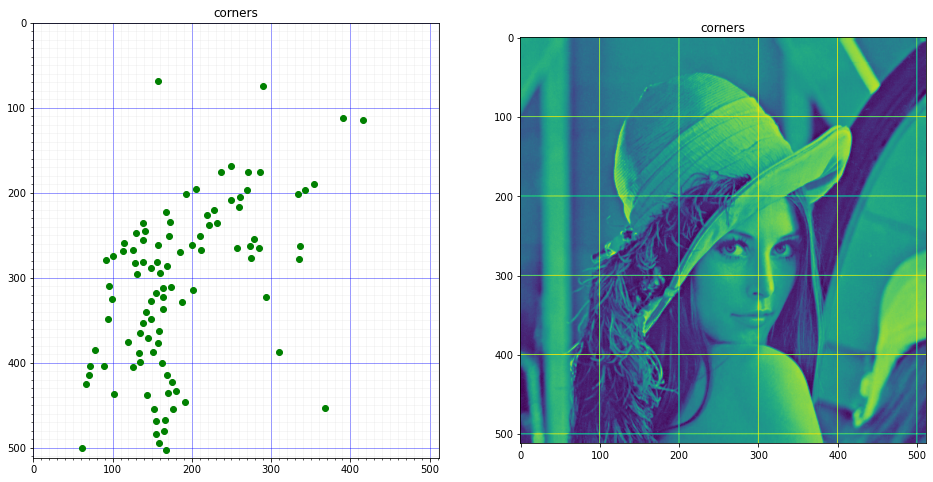

In [3]:
corners = cv2.goodFeaturesToTrack(image_orig, 100, 0.05, 10)



#######################################################
print_image('corners','corners',corners,0,2,0,15)

plt.figure(figsize=(16,8))

plt.subplot(121)
plt_view_grid(plt, 'on',(0,512,0,512),(100,10,100,10),major_color='b')
plt.title('corners')
plt.plot(corners[:,0,0],corners[:,0,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('corners')
plt.imshow(draw_grid(np.copy(image_orig),100,(255,255,255)))

plt.show()

<ipython-input-4-7abf1078d908>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img, (x, y), 3, 255, -1)


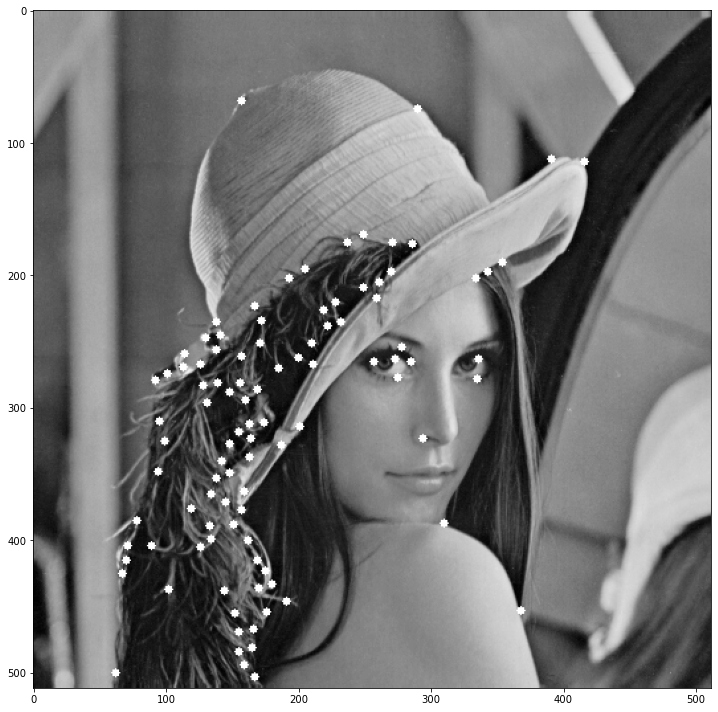

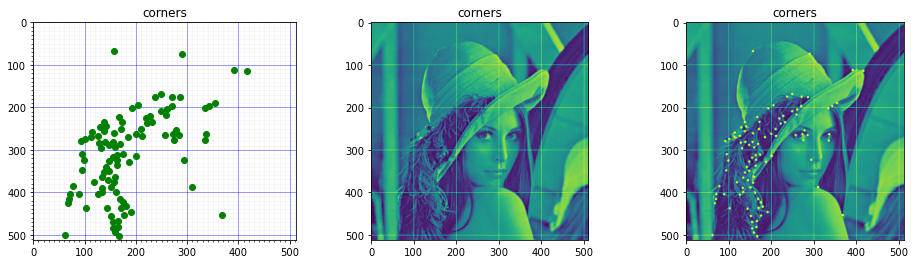

In [4]:
img = np.copy(image_orig)

for c in corners:
    x, y = c[0]
    cv2.circle(img, (x, y), 3, 255, -1)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.tight_layout()

plt.figure(figsize=(16,4))
plt.subplot(131)
plt_view_grid(plt, 'on',(0,512,0,512),(100,10,100,10),major_color='b')
plt.title('corners')
plt.plot(corners[:,0,0],corners[:,0,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(132)
plt.title('corners')
plt.imshow(draw_grid(np.copy(image_orig),100,(255,255,255)))

plt.subplot(133)
plt.title('corners')
plt.imshow(draw_grid(np.copy(img),100,(255,255,255)))

plt.show()

<ipython-input-5-42643cbd5467>:27: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_FASTsupres, tuple(p), 2, (0, 255, 0), cv2.FILLED)
<ipython-input-5-42643cbd5467>:31: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_FASTnotsupres, tuple(p), 2, (0, 255, 0), cv2.FILLED)


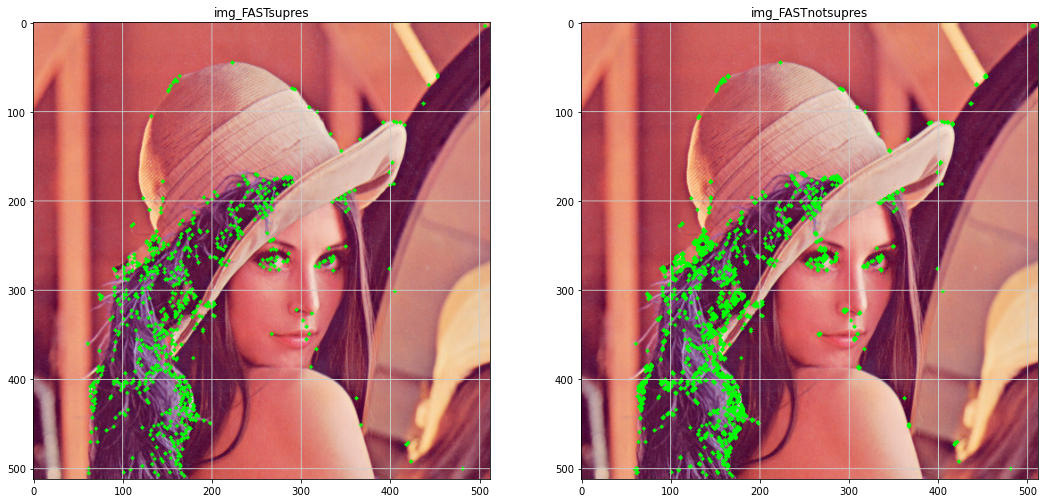

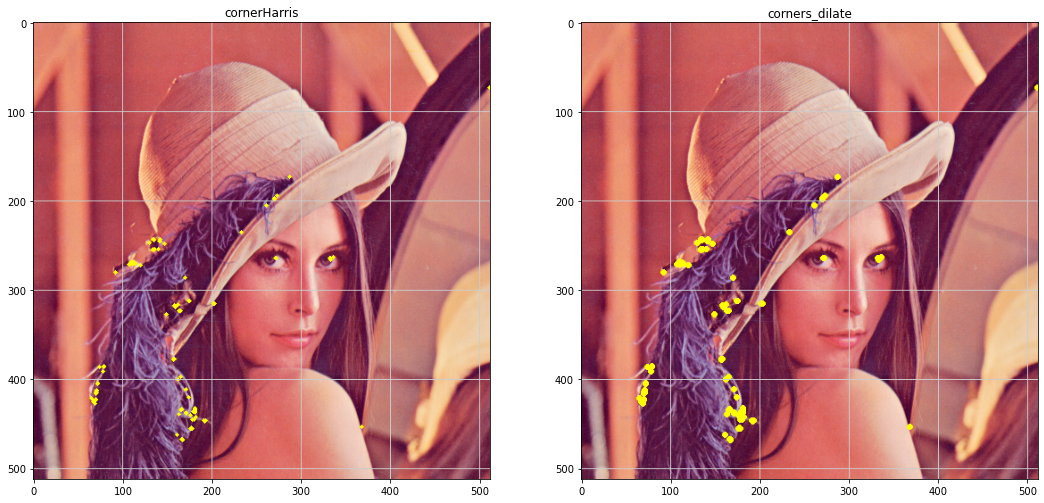

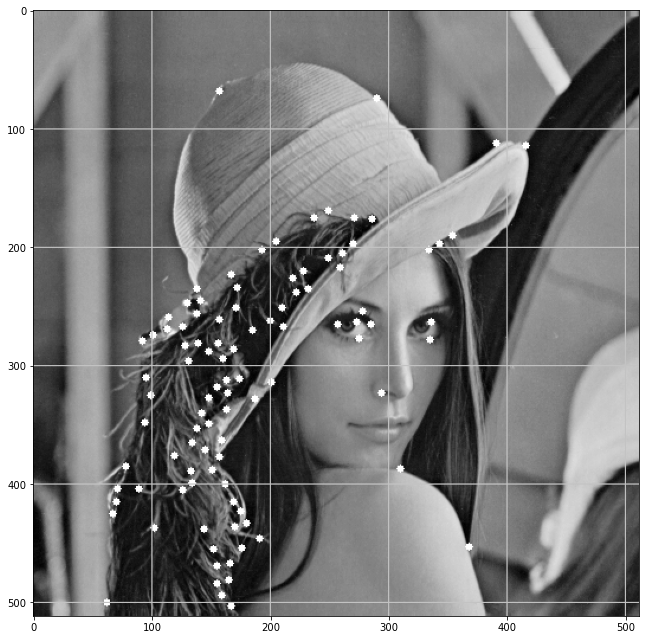

In [5]:
img_orig = cv2.imread('../data/Lena.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
cornerHarris = cv2.cornerHarris(np.copy(img_gray), 2, 3, 0.04)
img_cornerHarris = np.copy(img_orig)

max = cornerHarris.max()
for i in range(cornerHarris.shape[0]):
    for j in range(cornerHarris.shape[1]):
        if cornerHarris[i,j] >0.1*max:
            cv2.circle(img_cornerHarris, (j,i), 2, (0,255,255), cv2.FILLED)

corners_dilate = cv2.dilate(cornerHarris, None)
img_cornerDilate = np.copy(img_orig)
max = corners_dilate.max()
for i in range(corners_dilate.shape[0]):
    for j in range(corners_dilate.shape[1]):
        if corners_dilate[i,j] >0.1*max:
            cv2.circle(img_cornerDilate, (j,i), 2, (0,255,255), cv2.FILLED)
###################################
fast = cv2.FastFeatureDetector_create(30, True, cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
kp_supres = fast.detect(img_orig)
fast.setNonmaxSuppression(False)
kp_notsupres = fast.detect(img_orig)

img_FASTsupres = np.copy(img_orig)
for p in cv2.KeyPoint_convert(kp_supres):
    cv2.circle(img_FASTsupres, tuple(p), 2, (0, 255, 0), cv2.FILLED)

img_FASTnotsupres = np.copy(img_orig)
for p in cv2.KeyPoint_convert(kp_notsupres):
    cv2.circle(img_FASTnotsupres, tuple(p), 2, (0, 255, 0), cv2.FILLED)

plt_view_image(plt,[["img_FASTsupres",draw_grid(np.copy(img_FASTsupres))[:,:,[2,1,0]]],
                    ["img_FASTnotsupres", draw_grid(np.copy(img_FASTnotsupres))[:,:,[2,1,0]]]],
               figsize=(18,9), axis='on', cmap='gray')
plt_view_image(plt,[["cornerHarris",draw_grid(np.copy(img_cornerHarris))[:,:,[2,1,0]]],
                    ["corners_dilate", draw_grid(np.copy(img_cornerDilate))[:,:,[2,1,0]]]],
               figsize=(18,9), axis='on', cmap='gray')

plt.figure(figsize=(9, 9))
plt.imshow(draw_grid(np.copy(img)), cmap='gray')
plt.tight_layout()